In [10]:
#Import Important Libraries

import numpy as np
import tensorflow as tf
import os
import cv2
import shutil
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
# USING TENSORFLOW FOR USING 'GPU' FOR PROCESSING
# TENSORFLOW AUTOMATICALLY USE 'GPU' FOR PROCESSING
# TO AVOID OOM ERRORS RELATED ISSUE 


# LIST AVAILABLE GPU DEVICES
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # SET MEMORY GROWTH TO TRUE FOR EACH GPU
    tf.config.experimental.set_memory_growth(gpu,True)
    


In [8]:
# SPLITING THE DATASET
path_base= 'data/brain_tumor_dataset'
categories= ['no', 'yes']
splits= {'train': 0.7, 'val': 0.2, 'test': 0.1}

# CREATE DIRECTORIES
for split in splits:
    for category in categories:
        os.makedirs(os.path.join(path_base, split, category), exist_ok= True)

# SPLIT DATA
for category in categories:
    category_path= os.path.join(path_base, category)
    images= [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    # SPLIT DATA
    train_images, temp_images= train_test_split(images, test_size=splits['val'] + splits['test'], random_state=42)
    val_images, test_images= train_test_split(temp_images, test_size=splits['test'] / (splits['val'] + splits['test']), random_state=42)

    # MOVE FILES
    for image in train_images:
        shutil.move(os.path.join(category_path, image), os.path.join(path_base, 'train', category, image))
    for image in val_images:
        shutil.move(os.path.join(category_path, image), os.path.join(path_base, 'val', category, image))
    for image in test_images:
        shutil.move(os.path.join(category_path, image), os.path.join(path_base, 'test', category, image))

print("Data has been split and moved successfully.")
    



Data has been split and moved successfully.


In [11]:
# DEFINE DATA AUGMENTATION FOR THE TRAINING SET

train_datagen= ImageDataGenerator(
    rescale= 1./255,            # NORMALIZE PIXEL VALUE 0-255 TO 0-1
    rotation_range= 40,         # RANDOM ROTATION 
    width_shift_range= 0.2,     # RANDOM HORIZONTAL SHIFTS
    height_shift_range= 0.2,    # RANDOM VERTICAL SHIFTS
    shear_range= 0.2,           # RANDOM SHEARING
    zoom_range= 0.2,            # RANDOM ZOOM
    horizontal_flip= True,      # RANDOM HORIZONTAL FLIPS
    fill_mode= 'nearest'        # FILL PIXELS WITH THE NEAREST VALUE
)

In [15]:
# DEFINE DATA AUGMENTATION FOR THE VALIDATION AND TEST SETS

val_datagen= ImageDataGenerator(rescale=1./255)

In [17]:
# LOAD THE DATASETS FROM DIRECTORIES

train_data= train_datagen.flow_from_directory(
    'data/brain_tumor_dataset/train',
    target_size= (256,256),
    batch_size= 32,
    class_mode= 'binary'
)

val_data= val_dataget.flow_from_directory(
    'data/brain_tumor_dataset/val',
    target_size= (256,256),
    batch_size= 32,
    class_mode= 'binary'
)

test_data= val_datagen.flow_from_directory(
    'data/brain_tumor_dataset/test',
    target_size= (256,256),
    batch_size= 32,
    class_mode= 'binary',
    shuffle= False
)

Found 176 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [19]:
# DEFINE MODEL

from tensorflow.keras.layers import Input

model= Sequential([
    Input(shape=(256,256,3)),  # INPUT LAYER: SIZE 256*256 WITH 3 COLOUR CHANNEL RGB
    Conv2D(16,(3,3), strides= 1, activation= 'relu'),
    MaxPooling2D(),
    Conv2D(32,(3,3), strides= 1, activation= 'relu'),
    MaxPooling2D(),
    Conv2D(64,(3,3), strides= 1, activation= 'relu'), 
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [20]:
# COMPILE THE MODEL

model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [21]:
# DEFINE CALLBACKS

early_stopping= EarlyStopping(monitor= 'val_loss', patience= 5, restore_best_weights= True)
model_checkpoint= ModelCheckpoint('best_model.keras', monitor= 'val_accuracy', save_best_only= True)

In [23]:
# TRAIN THE MODEL

history= model.fit(
    train_data,
    validation_data= val_data,
    epochs= 40,
    callbacks= [early_stopping, model_checkpoint]
)

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step - accuracy: 0.7125 - loss: 0.5670 - val_accuracy: 0.7255 - val_loss: 0.4981
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.7740 - loss: 0.5189 - val_accuracy: 0.7451 - val_loss: 0.4687
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.6635 - loss: 0.6090 - val_accuracy: 0.6471 - val_loss: 0.7267
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - accuracy: 0.6818 - loss: 0.6667 - val_accuracy: 0.8627 - val_loss: 0.4897
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.7556 - loss: 0.5767 - val_accuracy: 0.8235 - val_loss: 0.4954
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step - accuracy: 0.7931 - loss: 0.5001 - val_accuracy: 0.7451 - val_loss: 0.4980
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.7296 - loss: 0.5276 - val_accuracy: 0.8431 - val_loss: 0.4662
Epoch 8/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.6918 - loss: 0.5649 - val_accuracy: 0.8235 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7692 - loss: 0.5121
Test accuracy: 0.7692


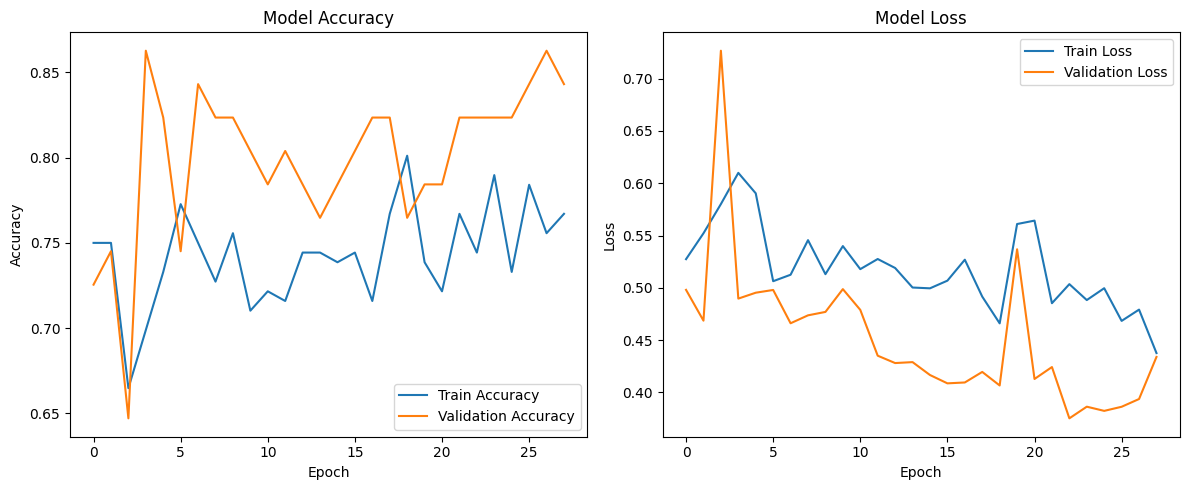

In [34]:
# EVALUATE THE MODEL ON TEST SET
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy:.4f}")

# PLOTING TRAINING AND VALIDATION ACCURACY AND LOSS
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\Dinesh\AppData\Local\Temp\ipykernel_20556\223139723.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_index= int(np.round(prediction[0]))  # GET THE CLASS INDEX FROM PREDICTION


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


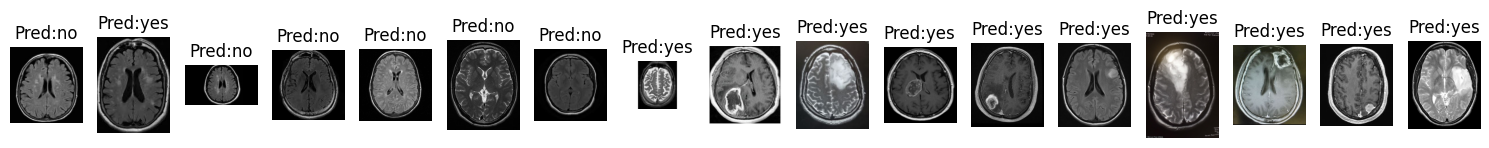

In [42]:
# LOAD AND PROCESS THE IMAGE FROM FOLDER
def load_images_from_folder(folder_path):
    image_paths= [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.lower().endswith(('.png','.jpg','.jpeg'))]
    return image_paths

def preprocess_image(image_path):
    img= cv2.imread(image_path)
    if img is None:
        print(f"Error loading image:{image_path}")
        return None
    img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img= cv2.resize(img,(256,256))  # Resize to the target size
    img= img/255.0  # Normalize pixel values to [0, 1]
    img= np.expand_dims(img,axis=0)  # Add batch dimension
    return img

def predict_and_display_images(folder_path,model,class_labels):
    image_paths= load_images_from_folder(folder_path)
    num_images= len(image_paths)
    
    if num_images== 0:
        print(f"No images found in folder:{folder_path}")
        return
    
    plt.figure(figsize=(15,5))
    
    for i,image_path in enumerate(image_paths):
        img= preprocess_image(image_path)
        if img is None:
            continue
        
        prediction= model.predict(img)
        class_index= int(np.round(prediction[0]))  # GET THE CLASS INDEX FROM PREDICTION
        predicted_class= class_labels[class_index]  # MAP THE INDEX TO CLASS LABEL
        
        # LOAD THE IMAGE FOR DISPLAY
        img_display= cv2.imread(image_path)
        if img_display is None:
            print(f"Error loading image for display:{image_path}")
            continue
        
        img_display= cv2.cvtColor(img_display,cv2.COLOR_BGR2RGB)  # BGR TO RGB
        
        plt.subplot(1,num_images,i + 1)
        plt.imshow(img_display)
        plt.title(f'Pred:{predicted_class}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# PATH OF THE FOLDER
folder_path= 'data/brain_tumor_dataset/check'

# LOAD CLASS LABELS
class_indices= train_data.class_indices
class_labels= {v: k for k, v in class_indices.items()}

# PREDICT AND DISPLAY THE MODEL
predict_and_display_images(folder_path,model,class_labels)

